# Compiling HuggingFace models for AWS Inferentia with SageMaker Neo

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

---

AWS Inferentia is Amazon's first custom silicon designed to accelerate deep learning workloads and is part of a long-term strategy to deliver on this vision. AWS Inferentia is designed to provide high performance inference in the cloud, to drive down the total cost of inference, and to make it easy for developers to integrate machine learning into their business applications. AWS Inferentia chips deliver up 2.3x higher throughput and up to 70% lower cost per inference than comparable current generation GPU-based Amazon EC2 instances, as we will confirm in the example notebook.

[AWS Neuron](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/) is a software development kit (SDK) for running machine learning inference using AWS Inferentia chips. It consists of a compiler, run-time, and profiling tools that enable developers to run high-performance and low latency inference using AWS Inferentia-based Amazon EC2 Inf1 instances. Using Neuron, you can bring your models that have been trained on any popular framework (PyTorch, TensorFlow, MXNet), and run them optimally on Inferentia. There is excellent support for Vision and NLP models especially, and on top of that we have released great features to help you make the most efficient use of the hardware, such as [dynamic batching](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/appnotes/perf/torch-neuron-dataparallel-app-note.html#dynamic-batching-description) or [Data Parallel](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-torch-neuron-dataparallel-api.html) inferencing.

SageMaker Neo saves you the effort of DIY model compilation, extending familiar SageMaker SDK API's to enable easy compilation for a [wide range](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents) of platforms. This includes CPU and GPU-based instances, but also Inf1 instances; in this case, SageMaker Neo uses the Neuron SDK to compile your model.

In this example notebook, we will deploy 2 HuggingFace NLP models for the task of paraphrase classification on SageMaker endpoints. One will be deployed on a GPU-accelerated instance, with no changes to the model; the other will be compiled and deployed to an Inf1 instance on SageMaker. Finally, we will perform a simple benchmark to compare the performance of both endpoints in terms of latency and throughput. 

## Setting up our environment

We first install some required Python packages, including `transformers`.
We also create a default sagemaker session, get our sagemaker role and default bucket.

In [1]:
!pip install -U transformers==4.15.0
!pip install -U sagemaker
# In this example, we are using torch 1.9 since this is the latest torch version that Neo supports for inferentia target
!pip install -U torch==1.9.1
!pip install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


If you run this notebook in SageMaker Studio, you need to make sure ipywidgets is installed and restart the kernel, so please uncomment the code in the next cell, and run it.

In [2]:
# %%capture
# import IPython
# import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [3]:
import transformers
import sagemaker
import torch

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sess_bucket = sagemaker_session.default_bucket()

## Getting model from HuggingFace Model Hub

We choose one of the most downloaded models from the HuggingFace Model Hub for our experiments - `distilbert-base-uncased`. [DistilBERT](https://huggingface.co/distilbert-base-uncased) is a transformer model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher in a knowledge distillation process. It is important to set the `return_dict` parameter to `False` when instantiating the model. In `transformers` v4.x, this parameter is `True` by default and it enables the return of dict-like python objects containing the model outputs, instead of the standard tuples. Neuron compilation does not support dictionary-based model ouputs, and compilation would fail if we didn't explictly set it to `False`.

We also get the tokenizer corresponding to this same model, in order to create a sample input to trace our model.  

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", return_dict=False
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

## Tracing model with `torch.jit` and uploading to S3 

In [5]:
from pathlib import Path

# Create directory for model artifacts
Path("traced_model/").mkdir(exist_ok=True)

We will create a sample input to `jit.trace` our model with PyTorch; this is a required step to have SageMaker Neo compile our model artifact, which will take a `tar.gz` file containing the traced model.

The `.pth` extension when saving our model is required.

In [6]:
# Prepare sample input for jit model tracing
seq_0 = "This is just sample text for model tracing, the length of the sequence does not matter because we will pad to the max length that Bert accepts."
seq_1 = seq_0
max_length = 512

tokenized_sequence_pair = tokenizer.encode_plus(
    seq_0, seq_1, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)

example = tokenized_sequence_pair["input_ids"], tokenized_sequence_pair["attention_mask"]

traced_model = torch.jit.trace(model.eval(), example)
traced_model.save("traced_model/model.pth")

In [ ]:
!tar -czvf traced_model.tar.gz -C traced_model . && mv traced_model.tar.gz traced_model/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
./
./traced_model.tar.gz
./model.pth


We upload the traced model `tar.gz` file to Amazon S3, where our compilation job will download it from

In [ ]:
traced_model_url = sagemaker_session.upload_data(
    path="traced_model/traced_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/traced-model",
)

## Understanding our inference code

Before we deploy any model, let's check out the code we have written to do inference on a SageMaker endpoint, with a default uncompiled model.

In [ ]:
!pygmentize code/inference_normal.py

As usual, we have a `model_fn` - receives the model directory, is responsible for loading and returning the model -, an `input_fn` and `output_fn` - in charge of pre-processing/checking content types of input and output to the endpoint - and a `predict_fn`, which receives the outputs of `model_fn` and `input_fn` (meaning, the loaded model and the deserialized/pre-processed input data) and defines how the model will run inference.

In this case, notice that we will load the model directly from the HuggingFace Model Hub for simplicity. `model_fn` will return a tuple containing both the model and its corresponding tokenizer. Both the model and the input data will be sent `.to(device)`, which can be a CPU or GPU, as we can see in line 7 of the file.

#### Now, lets see what changes in the inference code when we want to do inference with a model that has been compiled for Inferentia

In [ ]:
# This command outputs what you see in the cell after this one: only the model_fn in the inference_inf1.py file
%load -s model_fn code/inference_inf1.py

In [ ]:
# %load -s model_fn code/inference_inf1.py
def model_fn(model_dir):
    dir_contents = os.listdir(model_dir)
    model_path = next(filter(lambda item: "model" in item, dir_contents), None)

    tokenizer_init = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = torch.jit.load(os.path.join(model_dir, model_path))

    return (model, tokenizer_init)

In this case, within the `model_fn` we first grab the model artifact located in `model_dir` (the compilation step will name the artifact `model_neuron.pt`, but we just get the first file containing `model` in its name for script flexibility). Then, **we load the Neuron compiled model with `torch.jit.load`**. 

Other than this change to `model_fn`, we only need to add an extra import `import torch_neuron` to the beginning of the script, and get rid of all `.to(device)` calls, since the Neuron runtime will take care of loading our model to the NeuronCores on our Inferentia instance. All other functions are unchanged. 

## Deploying default model to GPU-backed endpoint

Now that we understand how we will do inference, we will first deploy a normal uncompiled model to a GPU-backed g4dn instance. Typically, this is a great instance type in terms of price-performance ratio that still provides GPU-acceleration.

Although we will be passing the `traced_model_url` as the `model_data` parameter to the `PyTorchModel` API, as we saw we will be pulling the model directly from the HuggingFace Model Hub directly in the inference script; this won't affect our benchmark in any way, since `model_fn` gets executed before any request even reaches the endpoint. We are using `PyTorchModel` here instead of the [HuggingFace specific](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html#hugging-face-model) (and optimized) [`HuggingFaceModel`](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html#hugging-face-model) for the simple reason that the latter is not integrated with SageMaker Neo at the time of writing, and we want to ensure a similar, standard setup for deploying both models. Anyhow, you will definitely benefit from using HuggingFace specific SageMaker API's if you are working with HuggingFace Models, but are not looking for model compilation.

Notice that we are passing `inference_normal.py` as our entry point script; also, the packages defined in the requirements file within our `source_dir` will automatically be installed on our endpoint instance. In this case we only need the latest version of the `transformers` library that is good to go on Inferentia instances, v. 4.15.0

In [24]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor
from datetime import datetime

prefix = "neuron-experiments/bert-seq-classification"
flavour = "normal"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

normal_sm_model = PyTorchModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    framework_version="1.8",
    role=role,
    sagemaker_session=sagemaker_session,
    entry_point="inference_normal.py",
    source_dir="code",
    py_version="py3",
    name=f"{flavour}-distilbert-pt181-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

In [25]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

hardware = "g4dn"

normal_predictor = normal_sm_model.deploy(
    instance_type="ml.g4dn.xlarge",
    initial_instance_count=1,
    endpoint_name=f"distilbert-{flavour}-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

------!

A quick test that our endpoint is responding as expected, using the sequences built further up in this notebook.

In [11]:
payload = seq_0, seq_1
normal_predictor.predict(payload)

'BERT predicts that "This is just sample text for model tracing, the length of the sequence does not matter because we will pad to the max length that Bert accepts." and "This is just sample text for model tracing, the length of the sequence does not matter because we will pad to the max length that Bert accepts." are paraphrase'

## Compiling and deploying model on Inferentia instance

We now create a new `PyTorchModel` that will use `inference_inf1.py` as its entry point script. PyTorch version 1.5.1 is the latest that supports Neo compilation to Inferentia, as you can see from the warning in the compilation cell output.

In [12]:
prefix = "neuron-experiments/bert-seq-classification"
flavour = "normal"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_sm_model = PyTorchModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    framework_version="1.9.1",
    role=role,
    sagemaker_session=sagemaker_session,
    entry_point="inference_inf1.py",
    source_dir="code",
    py_version="py3",
    name=f"{flavour}-distilbert-pt191-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

Finally, we are ready to compile the model. Two notes here:
* HuggingFace models should be compiled to `dtype` `int64`
* the format for `compiler_options` differs from the standard Python `dict` that you can use when compiling for "normal" instance types; for inferentia, you must provide a JSON string with CLI arguments, which correspond to the ones supported by the [Neuron Compiler](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html) (read more about `compiler_options` [here](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents))

In [13]:
%%time
import json

hardware = "inf1"
flavour = "compiled-inf"
compilation_job_name = f"distilbert-{flavour}-{hardware}-" + date_string

compiled_inf1_model = compiled_sm_model.compile(
    target_instance_family=f"ml_{hardware}",
    input_shape={"input_ids": [1, 512], "attention_mask": [1, 512]},
    job_name=compilation_job_name,
    role=role,
    framework="pytorch",
    framework_version="1.9.1",
    output_path=f"s3://{sess_bucket}/{prefix}/neo-compilations/{flavour}-model",
    compiler_options=json.dumps("--dtype int64"),
    #     compiler_options={'dtype': 'int64'},    # For compiling to "normal" instance types, cpu or gpu-based
    compile_max_run=900,
)

?????????????????????????????...............................................................................!CPU times: user 446 ms, sys: 35.7 ms, total: 482 ms
Wall time: 9min 31s


After successful compilation, we deploy our model to an inf1.xlarge instance.

In [14]:
%%time
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_inf1_predictor = compiled_inf1_model.deploy(
    instance_type="ml.inf1.xlarge",
    initial_instance_count=1,
    endpoint_name=f"test-neo-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

------------!CPU times: user 10.5 s, sys: 1.21 s, total: 11.7 s
Wall time: 6min 44s


Again, we test if everything is running smoothly in our endpoint.

In [15]:
# Predict with model endpoint
payload = seq_0, seq_1
compiled_inf1_predictor.predict(payload)

'BERT predicts that "This is just sample text for model tracing, the length of the sequence does not matter because we will pad to the max length that Bert accepts." and "This is just sample text for model tracing, the length of the sequence does not matter because we will pad to the max length that Bert accepts." are paraphrase'

## Benchmark and comparison

We will now perform a simple benchmark of both endpoints, using Python's `threading` module. In each benchmark, we start 5 threads that will each make 300 requests to the model endpoint. We measure the inference latency for each request, and we also measure the total time to finish the task, so that we can get an estimate of the request throughput/second.

**We first benchmark the uncompiled endpoint.**

In [16]:
import threading
import time

num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = normal_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Wait for threads, get an estimate of total time
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 139820680341248 started
Thread 139820690831104 started
Thread 139820548474624 started
Thread 139822626346752 started
Thread 139820725520128 started


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


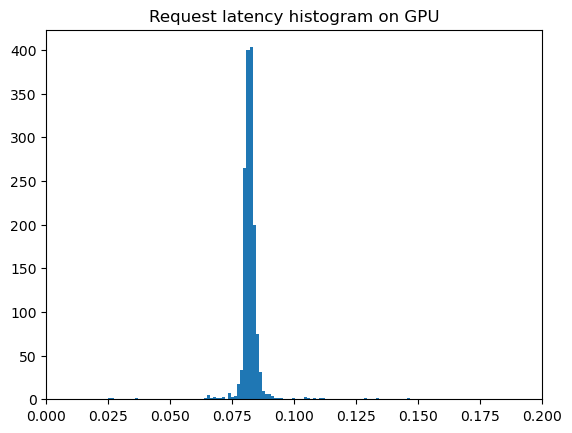

==== Default HuggingFace model on GPU benchmark ====

95 % of requests take less than 85.43497323989868 ms
Rough request throughput/second is 60.84935774632636


In [17]:
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS = (num_preds * num_threads) / end

t = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t, q=[50, 90, 95, 99])

hist(t, bins=100)
title("Request latency histogram on GPU")
xlim(0, 0.2)
show()

print("==== Default HuggingFace model on GPU benchmark ====\n")
print(f"95 % of requests take less than {latency_percentiles[2]*1000} ms")
print(f"Rough request throughput/second is {TPS}")

![Default Benchmark](images/default_benchmark.jpg)

We can see that request latency is pretty concentrated around the 85-90 millisecond range, and throughput is around ~60 TPS.

**Now, we benchmark our compiled model running on Inferentia**.

In [18]:
import threading
import time
import boto3

num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = compiled_inf1_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Make a rough estimate of total time, wait for threads
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 139820725520128 started
Thread 139822626346752 started
Thread 139820579944192 started
Thread 139820569454336 started
Thread 139820558964480 started


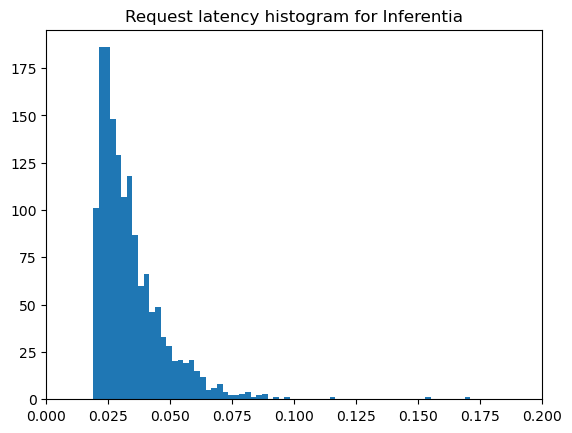

==== HuggingFace model compiled for Inferentia benchmark ====

95 % of requests take less than 59.43955183029174 ms
Rough request throughput/second is 144.55267532651578


In [19]:
from matplotlib.pyplot import hist, title, show, savefig, xlim
import numpy as np

TPS = (num_preds * num_threads) / end

t = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t, q=[50, 90, 95, 99])

hist(t, bins=100)
title("Request latency histogram for Inferentia")
xlim(0, 0.2)
show()

print("==== HuggingFace model compiled for Inferentia benchmark ====\n")
print(f"95 % of requests take less than {latency_percentiles[2]*1000} ms")
print(f"Rough request throughput/second is {TPS}")

![Compiled Benchmark](images/compiled_inf1_benchmark.jpg)

#### In this case, we can see that latency has dropped to a staggering 25-30 millisecond range - **around a 70% latency decrease** - while throughput has increased to 220 TPS - **almost a 400% increase**! 🤯🤯🤯

#### Best of all, the on-demand price of the Inferentia instance type we have used (ml.inf1.xlarge) for SageMaker Real Time Inference is **around 60% lower than ml.g4dn.xlarge, already the lowest-cost GPU instance option**  (Ireland region at the time of writing)

# Conclusions

#### The potential of Inferentia is obvious to anyone who has dipped their toe in to experiment with it; the increase in performance obtained from using it, paired with the steep cost reduction when compared to even the most cost efficient GPU-accelerated instances is extremely compelling.

#### Now, with a clear-cut way of compiling your models for Inferentia using the same familiar SageMaker SDK API's you already know (and love?), you can more easily take advantage of these benefits with little development effort or learning curve. 

### Clean up

In [20]:
normal_predictor.delete_model()
normal_predictor.delete_endpoint()
compiled_inf1_predictor.delete_model()
compiled_inf1_predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/sagemaker_neo_compilation_jobs|deploy_huggingface_model_on_Inf1_instance|inf1_bert_compile_and_deploy.ipynb)
